# Main file to run quantitative phase recovery and segment cells from it
* select and load raw brightfield data 
* set up phase recovery parameters
* calculate QP and save to file
* selection segmentation mode: 
    * whole volume
    * projection 
    * focal plane 
* set up cellpose model
* segment cells from QP  
* calculate dry mass from cell mask in QP


# load modules

In [ ]:
import numpy as np
import os
#import napari

from tpr import phase_structure
from tpr import TopographicPhaseRetrieval as ttpr

#cropXY, cropCoregMask, phase_structure, getQP
import tifffile as tf
from skimage import io
from tqdm import tqdm
from tkinter import filedialog
from tkinter import *
import matplotlib.pyplot as plt

In [2]:
def select_file(filepath=""):
    if not os.path.exists(filepath):
        # ask for user input for calibraiton
        root = Tk()
        root.withdraw()
        pathobject = filedialog.askopenfile(title='Select volumetric brightfield data', filetypes =[('image file', ['*.tif', '*.tiff'])])
        filepath = pathobject.name
        root.destroy()
    ht = os.path.split(filepath)
    path, fname = ht[0], ht[1]
    print(f"Selected file: {fname} from path {path}")
    return path, fname

def load_data(filename):
    return io.imread(filename)


def writeData(QP, path, filename, s): 
    outputImageFileName = os.path.join(path, filename)    
    if len(QP.shape) == 4:
        QP = np.transpose(QP, (2,1,0,3))
        print("4d")
        axes = 'ZYXT'
    else: 
        QP = np.transpose(QP, (2,1,0))
        print("3d")
        axes = "ZXY"
    print(QP.shape)
    tf.imwrite(
        outputImageFileName,
        QP,
        resolution=(1/s.optics_dx, 1/s.optics_dx),
        metadata={ 
            'spacing': s.optics_dz,
            'unit': 'um',
            'finterval': 1,
            'axes': axes
        })

    print(f"writing QP stack {outputImageFileName} finished.")


import json 
def write_phase_structure(s, path, filename=None):
    outputImageFileName = os.path.join(path, f"phase_structure.json")
    s.filename = filename

    with open(outputImageFileName, 'w') as fp:
        json.dump( s.__dict__ , fp)


def get_focus_metric(stack, plot_flag=False):
    fm = []
    for i in range(stack.shape[2]):
        #fm.append(laplacian(stack[i]))
        fm.append(compute_fourier_sharpness(np.squeeze(stack[:,:,i]), high_freq_cutoff=0.1))
    
    fm = np.array(fm)
    #fm_norm = fm/np.linalg.norm(fm)
    fm_norm = (fm - fm.min()) / (fm.max() - fm.min())
    if plot_flag:
        plt.figure(figsize=(10, 5))
        plt.title("Focus Metric")
        plt.plot(fm_norm, label='FFT Sharpness')
        plt.xlabel('Slice Index')
        plt.ylabel('Normalized Sharpness')
        plt.show()

    return fm_norm


def compute_fourier_sharpness(image, high_freq_cutoff=0.1):
    """
    Compute a sharpness score from the high-frequency content of an image using Fourier analysis.
    
    Parameters:
    - image (2D or 3D ndarray): Grayscale or RGB image.
    - high_freq_cutoff (float): Fraction (0-1) of radius to exclude low frequencies.
    
    Returns:
    - float: Sharpness score based on high-frequency energy.
    """
    # Normalize image
    image = image.astype(np.float32)
    image -= image.mean()

    # Fourier transform
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)

    # Create high-frequency mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    radius = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    mask = radius > (min(crow, ccol) * high_freq_cutoff)

    # Compute high-frequency energy
    high_freq_energy = np.sum((magnitude[mask])**2)
    return high_freq_energy


import numpy as np
import matplotlib.pyplot as plt

def under_curve_distance(
    x, y, *,
    baseline='min',
    peak_factor=0.5,
    peak_index=None,
    plot=False,
    ax=None,
    return_details=False,
):
    """
    Estimate the width of a single peak at a given fraction of its height
    (FWHM when peak_factor=0.5). Optionally plots the result.

    Parameters
    ----------
    x, y : array-like
        Sampled coordinates of the curve.
    baseline : {'min', None, float}, default 'min'
        Baseline level. 'min' uses min(y); None uses 0; or pass a float value.
    peak_factor : float, default 0.5
        Fraction of (peak - baseline) at which to measure the width.
        0.5 -> FWHM; 0.7 -> width at 70% of peak, etc.
    peak_index : int or None, default None
        Index of the peak to use. If None, the global argmax is used.
    plot : bool, default False
        If True, draw a small plot indicating the measured width.
    ax : matplotlib.axes.Axes or None
        Axes to plot on (created if None and plot=True).
    return_details : bool, default False
        If True, returns (width, xl, xr, level, i_peak). Otherwise returns width.

    Returns
    -------
    width : float
        Measured width (xr - xl) at the requested level, or np.nan if undefined.
    details : tuple (optional)
        Returned when return_details=True: (width, xl, xr, level, i_peak).
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # sort if needed
    if not np.all(np.diff(x) > 0):
        order = np.argsort(x)
        x, y = x[order], y[order]

    # baseline
    if baseline == 'min':
        y0 = float(np.min(y))
    elif baseline is None:
        y0 = 0.0
    else:
        y0 = float(baseline)

    # peak
    i_peak = int(np.argmax(y)) if peak_index is None else int(peak_index)
    ymax = y[i_peak]
    level = y0 + peak_factor * (ymax - y0)

    # left crossing (just left of the peak)
    i_left = np.where(y[:i_peak] <= level)[0]
    if len(i_left) == 0:
        result = (np.nan, np.nan, np.nan, level, i_peak)
        if plot:
            _plot_width(x, y, result, peak_factor, ax)
        return result if return_details else result[0]
    il = i_left[-1]
    xl = x[il] + (level - y[il]) * (x[il+1] - x[il]) / (y[il+1] - y[il])

    # right crossing (just right of the peak)
    i_right = np.where(y[i_peak:] <= level)[0]
    if len(i_right) == 0:
        result = (np.nan, xl, np.nan, level, i_peak)
        if plot:
            _plot_width(x, y, result, peak_factor, ax)
        return result if return_details else result[0]
    ir_rel = i_right[0]
    ir = i_peak + ir_rel - 1
    xr = x[ir] + (level - y[ir]) * (x[ir+1] - x[ir]) / (y[ir+1] - y[ir])

    width = xr - xl
    result = (width, xl, xr, level, i_peak)

    if plot:
        _plot_width(x, y, result, peak_factor, ax)

    return result if return_details else width


def _plot_width(x, y, result, peak_factor, ax=None):
    """Internal helper to draw the diagnostic plot."""
    width, xl, xr, level, i_peak = result

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.2, 3.6))
        created_ax = True

    ax.plot(x, y, label="data")
    ax.axhline(level, linestyle="--", linewidth=1,
               label=f"level = baseline + {peak_factor}*(peak-baseline)")

    if not np.isnan(width):
        # bracket and annotation
        ax.hlines(level, xl, xr, linestyles="-", linewidth=2)
        ax.annotate("", xy=(xl, level), xytext=(xr, level),
                    arrowprops=dict(arrowstyle="<->"))
        xm = 0.5 * (xl + xr)
        ax.annotate(f"width = {width:.3g}", xy=(xm, level),
                    xytext=(0, 12), textcoords="offset points",
                    ha="center", va="bottom")

    # labels & legend
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    title_txt = "FWHM" if abs(peak_factor - 0.5) < 1e-12 else f"Width at factor={peak_factor}"
    title_txt += f": {width:.3g}" if not np.isnan(result[0]) else ": undefined"
    ax.set_title(title_txt)
    ax.legend(loc="best")

    if created_ax:
        plt.tight_layout()
        plt.show()


# load data

In [17]:
path, filename = select_file()
stack = load_data(os.path.join(path, filename))
print(f"Finished loading, shape: {stack.shape}, dtype: {stack.dtype}")

path_out = os.path.join(path, "QP")
file_id = filename.split('.')[0] 
file_out = file_id + "_QP.tif"
proc = ttpr()

Selected file: stack.tif from path F:/irene
Finished loading, shape: (118, 1098, 1098), dtype: uint16


## Pre process stack
* permute if necessary, order should be x,y,z 
* lateral dimensions should be square (x==y!) 

In [18]:
Nx,Ny,Nz = stack.shape
#if stack.shape[0] != stack.shape[1] & stack.shape[1] == stack.shape[2]:
stack = np.transpose(stack, (1,2,0))
print(f"Stack shape after permutation: {stack.shape}")

Stack shape after permutation: (1098, 1098, 118)


In [19]:
stack=proc.cropXY(input_=stack)
Nz,Nx,Ny = stack.shape

print(f"Stack shape after cropping: {stack.shape}")

Cropping..
Cropping finished
Stack shape after cropping: (1098, 1098, 118)


In [20]:
stack = stack[:,:,::-1]  # flip z axis 

## setup phase processing

In [21]:
global PLOT_FLAG # set to global for now, need to change that in utils later
# PLOT_FLAG = True # set to true to plot the stack
PLOT_FLAG = False # set to false to not plot the stack

# Phase retrieval
# define optics and processing parameters
s=phase_structure()
s.optics_kzT = 0.01                 # Axial cutoff frequency
# if set to [], use the theoretical value
s.proc_mirrorX = False              # mirror the input stack along X 
s.proc_mirrorZ = True               # mirror the input stack along Z
s.proc_applyFourierMask = True
phase_structure.summarise(s)

Phase structure: 
_________________
s.optics_dx = 0.108 	 	 s.optics_wv = 0.58
s.optics_dz = 0.1 	 	 s.optics_dlambda = 0.075
s.optics_NA = 1.3 	 	 s.optics_alpha = 4.21
s.optics_NA_ill = 0.55 	 	 s.optics_kzT = 0.01
s.optics_n = 1.406
Processing paramters: 
_________________
s.proc_mirrorX = False 	 	 s.proc_mirrorZ = True
s.proc_applyFourierMask = True


## set parameters to GK setup 

In [22]:
# either write a metadata parser or set variables explicitly here
dz = 0.1  # z step size in microns
pixelsize = 0.102 # pixel size in microns

s.optics_dz = dz
s.optics_dx = pixelsize
s.optics_NA = 1.2 # numerical aperture
s.optics_NA_ill = 0.26 # illumination NA
s.optics_dlambda = 0.04
s.optics_wv = 0.55 # wavelength in microns
phase_structure.summarise(s)

Phase structure: 
_________________
s.optics_dx = 0.102 	 	 s.optics_wv = 0.55
s.optics_dz = 0.1 	 	 s.optics_dlambda = 0.04
s.optics_NA = 1.2 	 	 s.optics_alpha = 4.21
s.optics_NA_ill = 0.26 	 	 s.optics_kzT = 0.01
s.optics_n = 1.406
Processing paramters: 
_________________
s.proc_mirrorX = False 	 	 s.proc_mirrorZ = True
s.proc_applyFourierMask = True


# compute the phase

In [23]:
QP,mask = proc.getQP(stack=stack,struct=s)
print(f"Finished phase retrieval, shape: {QP.shape}, dtype: {QP.dtype}, range: {QP.min()} - {QP.max()}")

Finished phase retrieval, shape: (1098, 1098, 118), dtype: float64, range: -3.136365827197157 - 3.1375550127159237


## write QP to file

In [24]:
if not os.path.exists(path_out): #create output folder 
    os.mkdir(path_out)
    print("Created %s " % path_out)
    
writeData(QP, path_out, file_out, s)
write_phase_structure(s, path_out, filename)

3d
(118, 1098, 1098)
writing QP stack F:/irene\QP\stack_QP.tif finished.


## reload QP

In [25]:
QP = load_data(os.path.join(path_out, file_out))
print(f"Finished loading {file_out}, shape: {QP.shape}, dtype: {QP.dtype}, range: {QP.min()} - {QP.max()}")
if QP.shape[0] != QP.shape[1] & QP.shape[1] == QP.shape[2]:
    QP = np.transpose(QP, (1,2,0))
    print(f"Updated shape: {QP.shape}")

Finished loading stack_QP.tif, shape: (118, 1098, 1098), dtype: float64, range: -3.136365827197157 - 3.1375550127159237
Updated shape: (1098, 1098, 118)


## Which segmentation mode do you want to proceed - 3D, projection, focalplane?

In [26]:
mode = '2d' # '3d'
# if 3d, just continue with the segmentation, just need to select the appropriate cellpose model
# to ease processing, maybe reduce the z range

### 3D proccessing
maybe limit z range by intermediate slicing or crop the outer frames  

In [24]:
downsample_factor = 3 # downsample factor for speed, can be adjusted
QP_downsampled_z = QP[:,:,::downsample_factor] # downsample by factor of 2 for speed, can be adjusted
dz = s.optics_dz * downsample_factor # adjust z step size accordingly
QP_downsampled_z.shape

(1098, 1098, 40)

### 2D processing, projection
using the absolute maximum phase shift as selection but final image contains the negative and positive phase shifts 

In [57]:
#
idx = np.argmax(np.abs(QP), axis=2) # projection along z axis
img = np.zeros_like(idx, dtype=np.float32)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img[i,j] = QP[i,j,idx[i,j]]

### 2d processing, focal plane

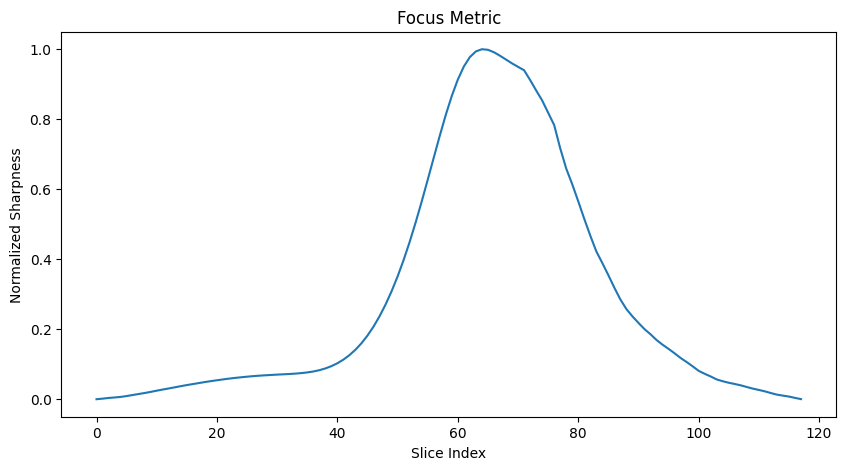

In [27]:
fp = np.argmax(get_focus_metric(QP, plot_flag=True))
img = QP[:,:,fp] # focal plane image


### disaply final image

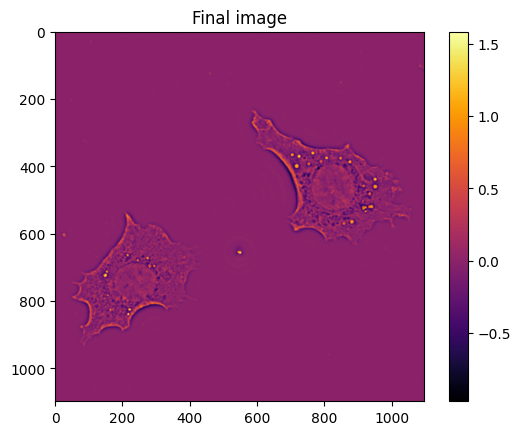

Image shape: (1098, 1098), dtype: float64, range: -0.9750861461329154 - 1.5855472385492067


In [28]:
plt.imshow(img, cmap='inferno')
plt.colorbar()
plt.title("Final image")
plt.show()
print(f"Image shape: {img.shape}, dtype: {img.dtype}, range: {img.min()} - {img.max()}")

## setup cellpose

In [29]:
from cellpose import models, core, io, plot
#from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if notebook instance has GPU access
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

if mode == '3d':
    is3d = True
    model_type = mode 
else:
    model_type = 'cyto'  # 'nuclei', 'cyto2'
    is3d = False

#model = models.CellposeModel(gpu=use_GPU, model_type=model_type)
model = models.CellposeModel(gpu=use_GPU)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.7.1+cu118! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-09-22 14:43:16,439 [INFO] WRITING LOG OUTPUT TO C:\Users\LocalAdmin\.cellpose\run.log
2025-09-22 14:43:16,441 [INFO] 
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.7.1+cu118
2025-09-22 14:43:16,735 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? YES
2025-09-22 14:43:16,737 [INFO] ** TORCH CUDA version installed and working. **
2025-09-22 14:43:16,738 [INFO] >>>> using GPU (CUDA)
2025-09-22 14:43:18,826 [INFO] >>>> loading model C:\Users\LocalAdmin\.cellpose\models\cpsam


## 2d modelsegmentation

In [31]:
fp

64

In [49]:
# choose image
img = QP[:,:,84] # focal plane image

2025-09-22 15:10:41,998 [WARNING] Resizing is depricated in v4.0.1+


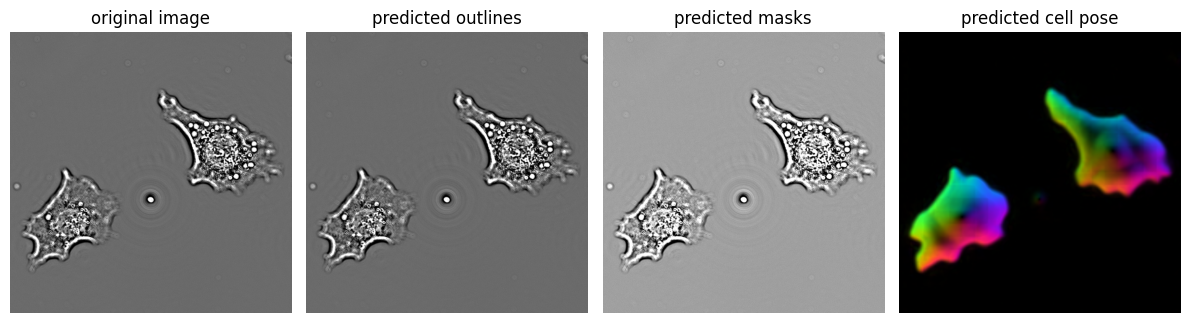

In [50]:
flow_threshold = 0.2
cellprob_threshold = 0
diam = 189#189

mask, flow, style = model.eval(img, batch_size=256, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, do_3D=is3d, diameter=diam)
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, mask, flow[0])
plt.tight_layout()
plt.show()

# 3d segmentation

In [33]:
start_slice = 60 #45
end_slice = 70 #85

#QP_sliced =QP_downsampled_z[:,:,start_slice:end_slice]
QP_sliced =QP[:,:,start_slice:end_slice]
print(f"QP_sliced shape: {QP_sliced.shape}")

QP_sliced shape: (1098, 1098, 10)


In [ ]:
downsample_factor_xy = 3 # downsample factor for speed, can be adjusted
QP_seg =QP_sliced[::downsample_factor_xy,::downsample_factor_xy,:]
dxy = s.optics_dx * downsample_factor_xy
print(f"QP_sliced shape: {QP_sliced.shape}")

(366, 366, 10)

In [36]:
# try some 3d stuff
flow_threshold = 0.2
cellprob_threshold = 0
diam=30.0


anisotropy = np.rint(dxy/dz)  # adjust if needed, 1.0 means isotropic
print(f"Anisotropy: {anisotropy}")
masks, flows, styles = model.eval(QP_seg, #QP_sliced, 
                                  batch_size=32, 
                                  flow_threshold=flow_threshold, 
                                  cellprob_threshold=cellprob_threshold, 
                                  do_3D=True, 
                                  #stitch_threshold=0.5,
                                  diameter=diam, 
                                  z_axis=2,
                                  #min_size=1000, 
                                  flow3D_smooth=1, 
                                  anisotropy=anisotropy
                                  )


Anisotropy: 1.0
2025-08-15 17:28:30,207 [INFO] running YX: 10 planes of size (366, 366)
2025-08-15 17:28:36,455 [INFO] 100%|##########| 2/2 [00:06<00:00,  3.12s/it]
2025-08-15 17:28:36,469 [INFO] running ZY: 366 planes of size (10, 366)
2025-08-15 17:30:30,739 [INFO] 100%|##########| 23/23 [01:54<00:00,  4.97s/it]
2025-08-15 17:30:30,783 [INFO] running ZX: 366 planes of size (10, 366)
2025-08-15 17:32:26,671 [INFO] 100%|##########| 23/23 [01:55<00:00,  5.04s/it]
2025-08-15 17:32:27,016 [INFO] network run in 236.81s
2025-08-15 17:32:27,017 [INFO] smoothing flows with sigma=1
2025-08-15 17:32:27,505 [INFO] masks created in 0.17s


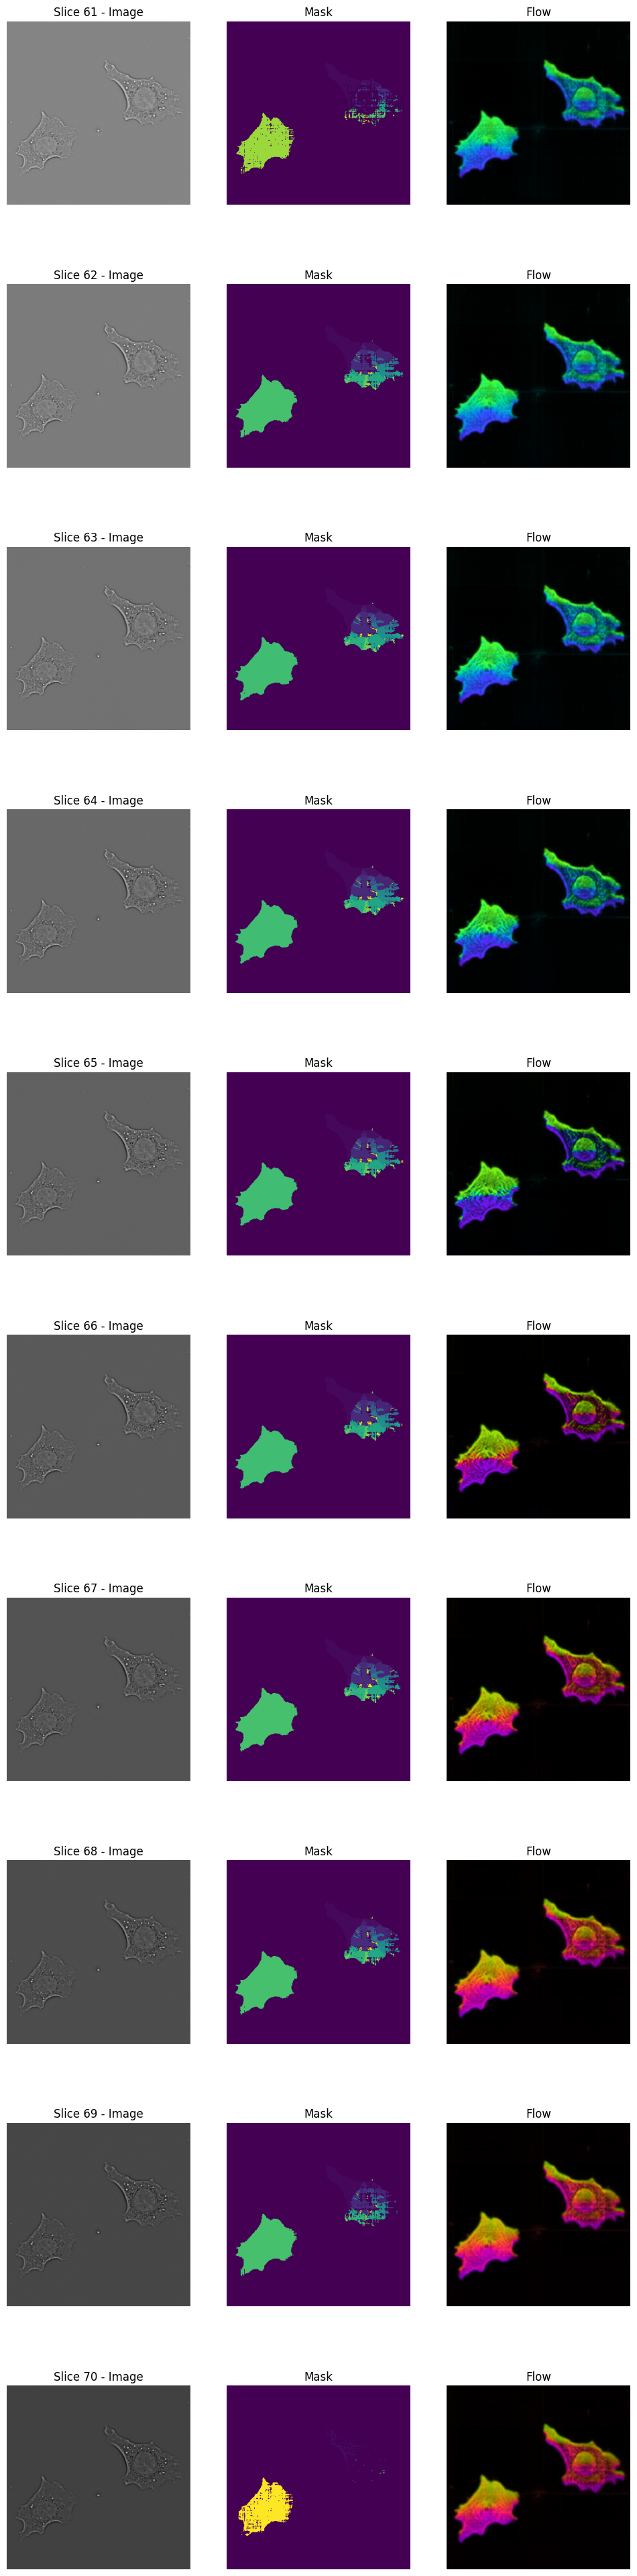

In [37]:
fig, axs = plt.subplots(nrows=masks.shape[0], ncols=3, figsize=(12, 5 * masks.shape[0]))
for i in range(masks.shape[0]):
    img = QP_sliced[:,:,i]
    
    #print(f"Processing slice {i+1}/{masks.shape[0]}")
    axs[i,0].imshow(img, cmap='gray')
    axs[i,1].imshow(masks[i])
    axs[i,2].imshow(flows[0][i,...])

    for j in range (axs.shape[1]):
        axs[i,j].axis('off')

    axs[i,0].set_title(f"Slice {start_slice+i+1} - Image")
    axs[i,1].set_title("Mask")
    axs[i,2].set_title("Flow")

    #plot.show_segmentation(fig, img, masks[i], flows[0][i,...])

#plt.tight_layout()
plt.show()

# Convert phase shift to refractive index 
needs either saaple thickness map (== volume segmentation) or assuming an average thickness 
$$
n(x, y) = \frac{\phi(x, y) \cdot \lambda}{2\pi \, t(x, y)} + n_{\text{med}}
$$


In [71]:
import skimage as ski
n_med = 1.335# refractive indext of the medium, e.g. 1.33 for water, 1.335 for PBS
# refraction increment
alpha =.18 * 10**(-6) # [m^3/g]  .18 in [ µm3 pg−1]
wv =  s.optics_wv * 10**(-6) # [m]
pixelsize = s.optics_dx * 10**(-6) # [m]
dz= s.optics_dz * 10**(-6) # [m]
print(f"Alpha: {alpha} [m^3/g], Wavelength: {wv} [m], Pixel size: {pixelsize} [m], dz: {dz} [m]")

Alpha: 1.8e-07 [m^3/g], Wavelength: 5.5e-07 [m], Pixel size: 1.0199999999999999e-07 [m], dz: 1e-07 [m]


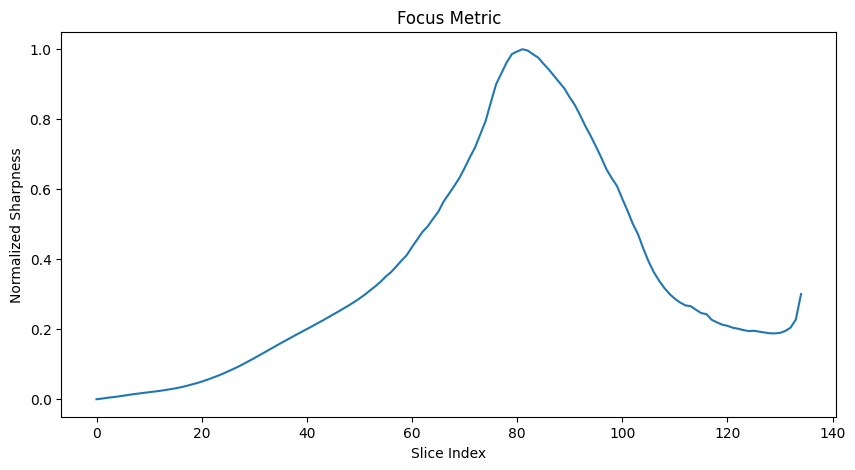

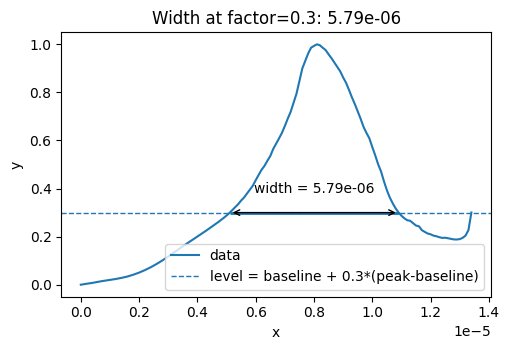

In [72]:
# do a thickness estimation based on the fourier sharpness focus metric
stage_z = np.linspace(0, (QP.shape[2]-1)*dz, QP.shape[2]) # z positions in microns
fm = get_focus_metric(QP, plot_flag=True)
thickness_global =  under_curve_distance(stage_z, fm, peak_factor=0.3, plot=True) # thickness in mL/g

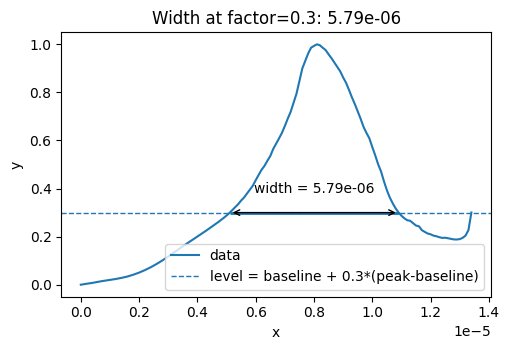

array([[5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06],
       [5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06],
       [5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06],
       ...,
       [5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06],
       [5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06],
       [5.7915136e-06, 5.7915136e-06, 5.7915136e-06, ..., 5.7915136e-06,
        5.7915136e-06, 5.7915136e-06]], dtype=float32)

In [73]:
# find a global thickness estimate based on the contrast in the image
thickness_global = under_curve_distance(stage_z, fm, peak_factor=0.3, plot=True, return_details=False)
# convert it to map with the size of the image
thickness = np.ones_like(img)*thickness_global
thickness

$$
n(x, y) = \frac{\phi(x, y) \cdot \lambda}{2\pi \, t(x, y)} + n_{\text{med}}
$$


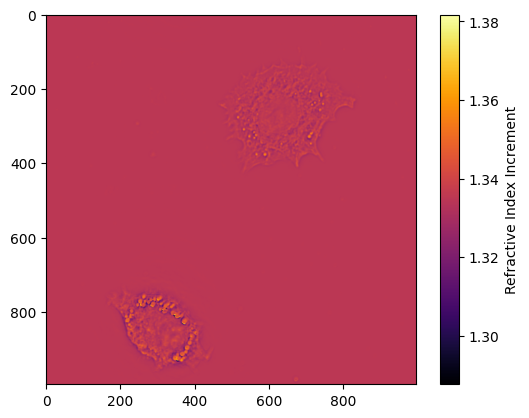

In [77]:
ri = ((img * wv ) / (2 * np.pi * thickness)) + n_med# refractive index increment
ri.shape
plt.imshow(ri, cmap='inferno')
plt.colorbar(label='Refractive Index Increment')
plt.show()

# Calculate dry mass (finally)

### 2d phase retardation image

If the embedding medium has the same refractive index as the intracellular solute ($𝑛_{med} =𝑛_{intra})$ then 

$$
m_{\text{med}=\text{intra}} = \frac{\lambda}{2 \pi \alpha} \cdot \iint \phi(x, y) \, dx \, dy
$$


for a discrete image 

$$
m_{\text{med}=\text{intra}} = \frac{\lambda}{2 \pi \alpha} \cdot \Delta A \cdot \sum_{i,j} \phi(x_i, y_j)
$$

with the pixel area ∆𝐴 and a pixel-wise summation of the phase data

#### Expected values
* area: hundreds of square microns == $m^{-10}$ 
* mass: hundreds picograms ==  $g^{-10}$ 

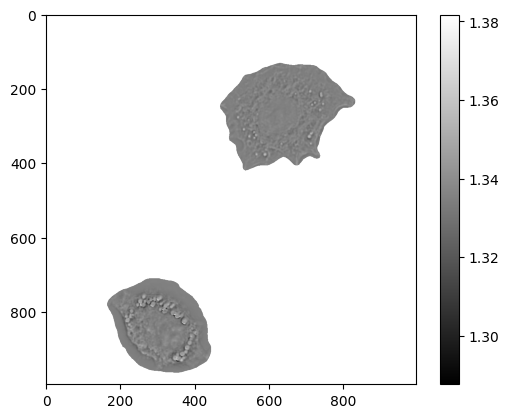

Processing region 1/2
Processing region 2/2


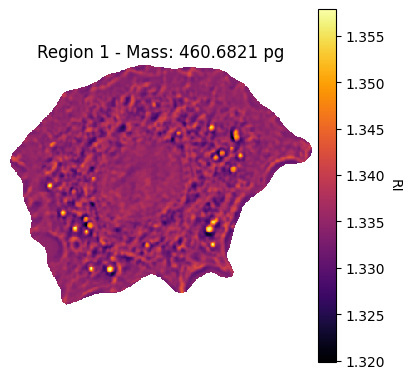

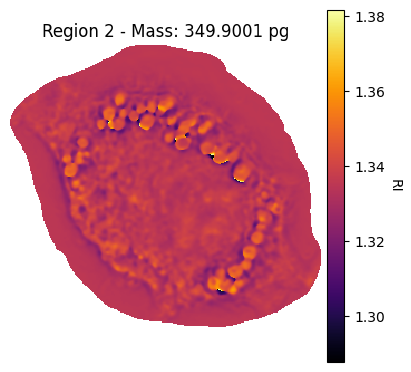

In [78]:
phase_masked = np.zeros_like(mask, dtype=np.float32)
m=(mask>0).astype(np.int8)  # convert mask to int for multiplication
img_masked = ri * m  # img # mask the image with the segmentation mask  
img_masked[img_masked==0] = None

plt.imshow(img_masked, cmap='gray')
plt.colorbar()
plt.show()

label = ski.measure.label(mask)
props = ski.measure.regionprops(label, intensity_image=img_masked)
cell = {}
pixel_area = pixelsize**2
for ii, p in enumerate(props):
    print(f"Processing region {ii+1}/{len(props)}")
    cell_data = p.image_intensity
    area = p.area_filled * pixel_area  # area in m^2
    
    cell[ii] = {}
    cell[ii]['mass'] = np.nansum(cell_data) * wv * pixel_area / (2*np.pi*alpha) # mass in g 
    cell[ii]['area'] = area # area in m^2

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100, constrained_layout=True)
    im = ax.imshow(cell_data, cmap='inferno', interpolation="nearest")
    ax.set_title(f"Region {ii+1} - Mass: {cell[ii]['mass']*10**(12):.4f} pg")
    ax.set_xticks([]); ax.set_yticks([])      # same as ax.axis('off') but keeps the frame if you want
    ax.set_frame_on(False)

    # Attach colorbar to THIS image
    cbar = fig.colorbar(im, ax=ax, pad=0.02, shrink=0.9)
    cbar.set_label("RI", rotation=270, labelpad=12)

    cell[ii]['figure'] = fig
    cell[ii]['data'] = cell_data
    cell[ii]['mode'] = mode
    cell[ii]['fp'] = fp  if fp not in locals() else None # focal plane index

    # write processing parameters to cell dictionary
    cell[ii]['thickness'] = thickness_global if thickness_global not in locals() else None  # global thickness estimate
    cell[ii]['alpha'] = alpha if alpha not in locals() else None  # refraction increment
    cell[ii]['wv'] = wv if wv not in locals() else None  # wavelength
    cell[ii]['pixelsize'] = pixelsize if pixelsize not in locals() else None  # pixel size
    cell[ii]['dz'] = dz if dz not in locals() else None




## save data and masks

In [79]:
path_results = os.path.join(path, "results") 
if not os.path.exists(path_results): #create output folder
    os.mkdir(path_results)
    print("Created %s " % path_results)

#### write figures

In [83]:
for c in cell:
    fig = cell[c]['figure']
    fig.savefig(os.path.join(path_results, f"{file_id}_cell_{c+1}.png"), dpi=300)

    ski.io.imsave(os.path.join(path_results, f"{file_id}_cell_{c+1}.tif"), cell[c]['data'], check_contrast=False)
    plt.close(fig)


io.save_masks(img, mask, flow, file_names=os.path.join(path_results, file_out))

#### write csv 

In [84]:
import pandas as pd 
outkeys = [k for k in cell[0].keys() if k not in ['figure', 'data']] 
df = pd.DataFrame([{k: cell[ii][k] for k in outkeys} for ii in range(len(cell))])

In [85]:
df.to_csv(os.path.join(path_results, f"{file_id}_cell_data.csv"), index=True)

# literature
Overestimation of dry mass due to single alpha factor for protein density?
Lipid density (g/ml) is about half of protein
* https://www.frontiersin.org/files/Articles/1017499
    * https://www.frontiersin.org/files/Articles/1017499/fcell-10-1017499-HTML/image_m/fcell-10-1017499-g001.jpg
    
* short term (pulsative) cyclic dry mass changes in asynchronous cell cultures
    *   https://doi.org/10.1038/s41598-020-79661-9
    
